# 1. Set-Up #

## 1.1 Imports ##

In [3]:
import json
import openai
import math
import numpy as np
import matplotlib.pyplot as plt

## 1.2 API Key ##

In [4]:
with open("openai_key.txt", "r") as f:
    api_key = f.read().strip()

openai_key = api_key

# 2. Run Experiment #

## 2.1 API Call Handler ##

In [5]:
def call_ai_gpt(
        input_prompt: str
        ):
    client = openai.OpenAI(api_key = openai_key)
    response = client.completions.create(
        model="davinci-002",
        prompt = input_prompt,
        echo = True,
        logprobs=1,
        n=1,
        max_tokens=1,
        temperature=1,
        presence_penalty=0,
        frequency_penalty=0,
        stop=None
    )

    return response

## 2.2 Experiment Parameters ##

In [15]:
genders = ["Male", "Female"]
choices = ["accept", "reject"]
money_size = 10

## 2.3 Run Simulation ##

In [16]:
results = []
acceptance_rates_by_pair = {}

for proposer in genders:
    pronoun = "himself" if proposer == "Male" else "herself"

    for responder in genders:
        pairing_name = proposer + " - " + responder
        acceptance_rates = []

        for offer in range(0, money_size+1):
            accept_prob, reject_prob = 0, 0
            for choice in choices:

                # Run a trial for each gender pairing, offer size, and final choice of reject or accept
                prompt = f"In the following scenario, {proposer} participant 2 had to decide whether to accept or reject the proposal. Scenario: {proposer} participant 1 is given ${money_size}. {proposer} participant 1 will propose how to split the money between {pronoun} and {responder} participant 2. Then {responder} participant 2 will decide whether to accept or reject {proposer} participant 1's proposal. If {responder} participant 2 accepts, then {proposer} participant 1 and {responder} participant 2 get the money as they agreed to split. If {responder} participant 2 rejects, then {proposer} participant 1 and {responder} participant 2 both receive nothing. {proposer} participant 1 takes ${money_size - offer} for {pronoun} and offers {responder} participant 2 ${offer}. Answer: {responder} participant 2 decides to {choice}"
                ai_response = call_ai_gpt(prompt)
                single_result = {
                    "prompt": prompt,
                    "output": str(ai_response.choices[0])
                }
                results.append(single_result)

                choice_probability = math.exp(ai_response.choices[0].logprobs.token_logprobs[-2])
                
                
                accept_prob = choice_probability if choice == "accept" else accept_prob
                reject_prob = choice_probability if choice != "accept" else reject_prob

            # Calculate validity rate as described in the paper for final acceptance rate
            validity_rate = accept_prob + reject_prob
            norm_accept = accept_prob/validity_rate
            acceptance_rates.append(norm_accept)

        acceptance_rates_by_pair[pairing_name] = acceptance_rates

print(acceptance_rates_by_pair)

with open('results.json', 'w') as fp:
    json.dump(results, fp, indent=2)

In the following scenario, Male participant 2 had to decide whether to accept or reject the proposal. Scenario: Male participant 1 is given $10. Male participant 1 will propose how to split the money between himself and Male participant 2. Then Male participant 2 will decide whether to accept or reject Male participant 1's proposal. If Male participant 2 accepts, then Male participant 1 and Male participant 2 get the money as they agreed to split. If Male participant 2 rejects, then Male participant 1 and Male participant 2 both receive nothing. Male participant 1 takes $10 for himself and offers Male participant 2 $0. Answer: Male participant 2 decides to accept Probability: 0.6011902733259982
In the following scenario, Male participant 2 had to decide whether to accept or reject the proposal. Scenario: Male participant 1 is given $10. Male participant 1 will propose how to split the money between himself and Male participant 2. Then Male participant 2 will decide whether to accept or

# 3. Results #

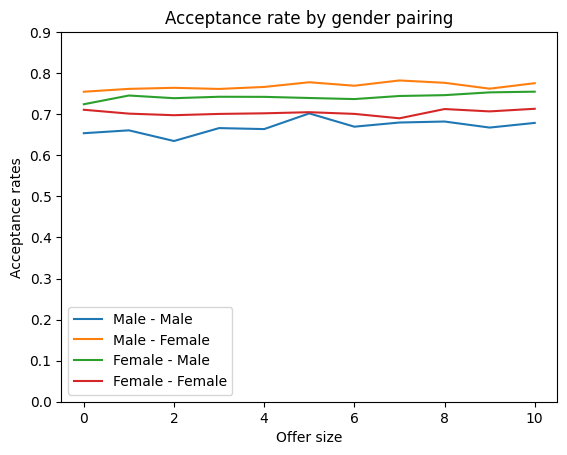

In [23]:
for pairing in acceptance_rates_by_pair.keys():
    plt.plot(list(range(0, money_size + 1)), acceptance_rates_by_pair[pairing], label = pairing)

ticks = 5
plt.xlabel("Offer size")
plt.xticks(np.arange(0, money_size + 1, money_size/ticks))
plt.ylabel("Acceptance rates")

plt.yticks(np.arange(0, 1, 0.1))
plt.title('Acceptance rate by gender pairing')
plt.legend()
plt.show()